In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/with_features.csv')
df.dropna(inplace=True)
df.head()

,time,longitude,latitude,depth,mag,magType,time_disc,longitude_disc,latitude_disc,pos,lat_cent,lon_cent,plate_region,dist_region,dist,plate,label
0,1973-01-01 01:05:56.150,-117.588000,34.189833,6.000,1.70,5,1973-01-01,-118,34,34_-118,34.5,-117.5,1,16.691592,19.302507,1,0
1,1973-01-01 04:46:09.800,150.634000,-9.214000,41.000,5.30,3,1973-01-01,150,-10,-10_150,-9.5,150.5,51,21.124956,55.729840,61,0
2,1973-01-01 05:20:59.780,-122.117333,48.308667,13.680,2.20,2,1973-01-01,-123,48,48_-123,48.5,-122.5,3,296.114618,314.738391,3,0
3,1973-01-01 06:22:29.800,-173.958000,-15.012000,33.000,5.00,3,1973-01-01,-174,-16,-16_-174,-15.5,-173.5,34,84.317941,18.239739,42,0
4,1973-01-01 08:58:11.460,-155.360833,19.443667,7.302,1.85,1,1973-01-01,-156,19,19_-156,19.5,-155.5,2,3527.668174,3522.498687,2,0


In [3]:
SPLIT_DATE_TRAIN: str = "2020-01-01"
SPLIT_DATE_VAL: str = "2023-01-01"

In [4]:
len(df), len(df[df['time'] < SPLIT_DATE_TRAIN]), len(df[(df['time'] >= SPLIT_DATE_TRAIN) & (df["time"] < SPLIT_DATE_VAL)]), len(df[df['time'] >= SPLIT_DATE_VAL])

(4100006, 3488698, 501751, 109557)

In [5]:
df_f = df[df["time"] <= SPLIT_DATE_TRAIN]
df_agg = df_f.groupby(["pos"]).agg({"mag": "count"}).reset_index()

In [6]:
len(df_agg[df_agg["mag"] < 150]) / len(df_agg)

0.8921700577943156

In [7]:
len(df_f[df_f["pos"].isin(df_agg[df_agg["mag"] >= 150]["pos"].values)]) / len(df_f)

0.9460784510439137

In [8]:
df_agg["mag"].min(), df_agg["mag"].max()

(1, 307355)

In [27]:
d = df_agg["mag"].values

In [29]:
d = np.sort(d)
d = d[:-10]

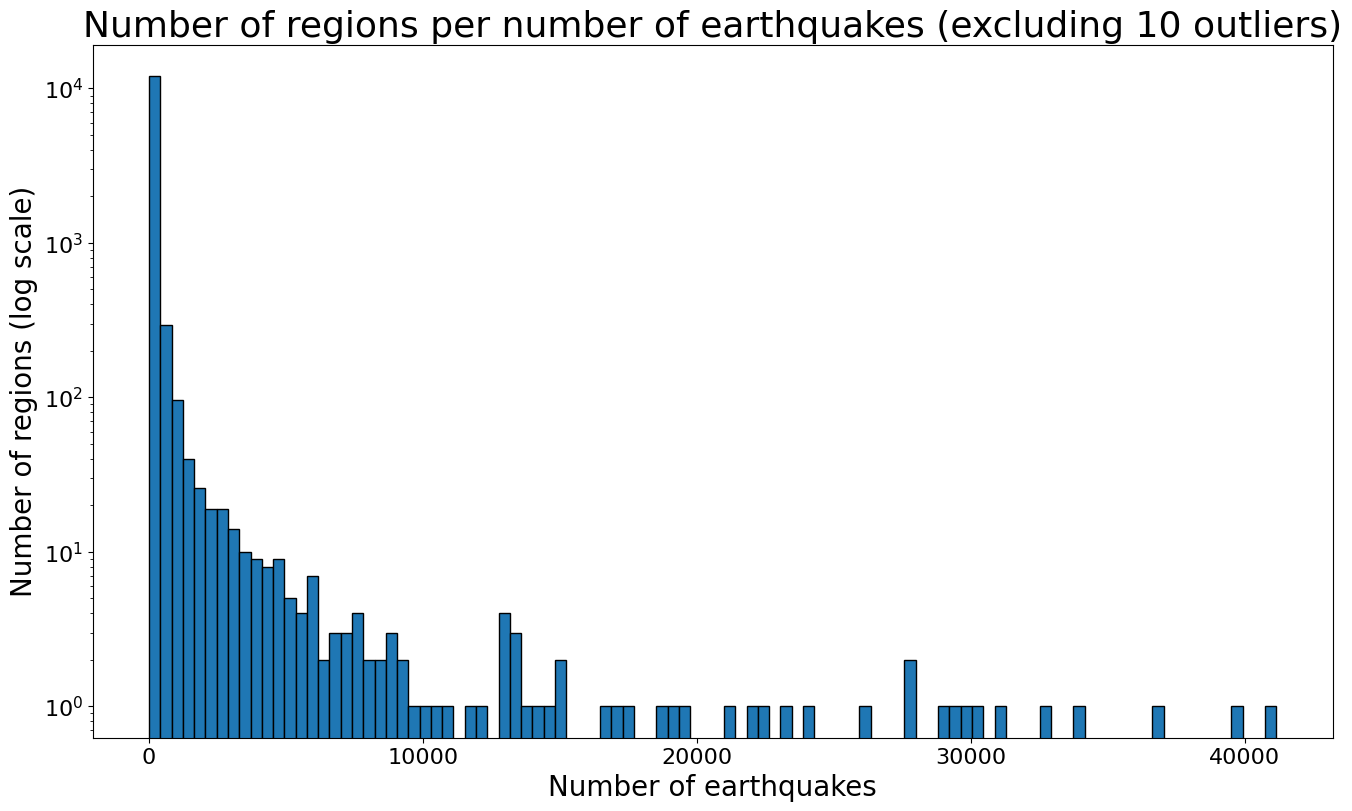

In [31]:
plt.figure(figsize=(16, 9))
plt.hist(d, bins=100, edgecolor="black")
plt.yscale("log")
plt.title("Number of regions per number of earthquakes (excluding 10 outliers)", fontsize=26)
plt.xlabel("Number of earthquakes", fontsize=20)
plt.ylabel("Number of regions (log scale)", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

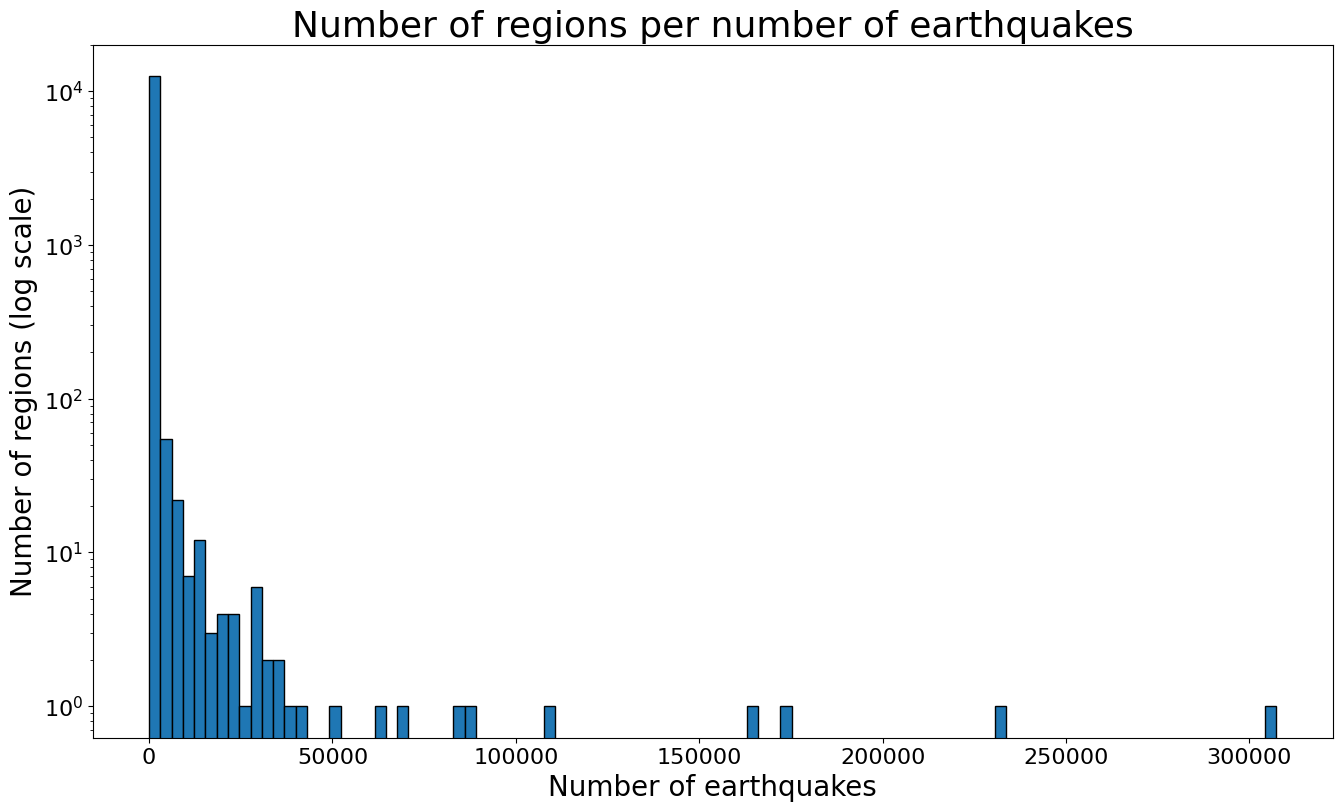

In [9]:
df_agg["mag"].hist(bins=100, figsize=(16, 9), edgecolor="black")
plt.yscale("log")
plt.title("Number of regions per number of earthquakes", fontsize=26)
plt.xlabel("Number of earthquakes", fontsize=20)
plt.ylabel("Number of regions (log scale)", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

In [11]:
df = df[df["time"] < SPLIT_DATE_TRAIN]

In [12]:
def filter_regions(df: pd.DataFrame, threshold: int) -> pd.DataFrame:
    df_f = df[df["time"] <= SPLIT_DATE_TRAIN]
    df_agg = df_f.groupby(["pos"]).agg({"mag": "count"}).reset_index()
    tmp = df_agg.loc[df_agg["mag"] >= threshold, "pos"].values
    df = df[df["pos"].isin(tmp)]
    return df

In [13]:
n = 40

In [14]:
counts1 = []
counts2 = []
for th in np.linspace(1, n, n):
    df_filter = filter_regions(df.copy(deep=True), th)
    counts1.append(df_filter["pos"].nunique())
    counts2.append(len(df_filter))

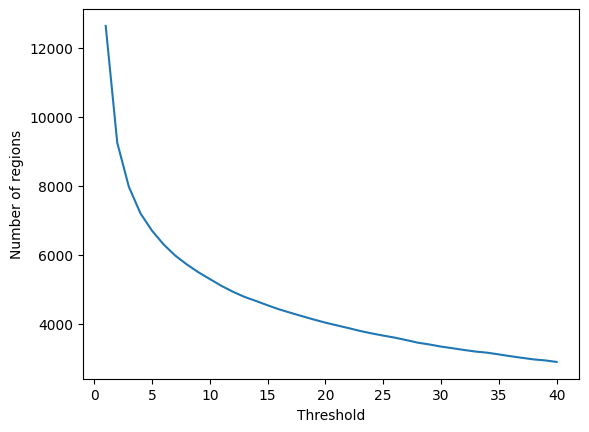

In [15]:
# plot counts
plt.plot(np.linspace(1, n, n), counts1)
plt.xlabel("Threshold")
plt.ylabel("Number of regions")
plt.show()

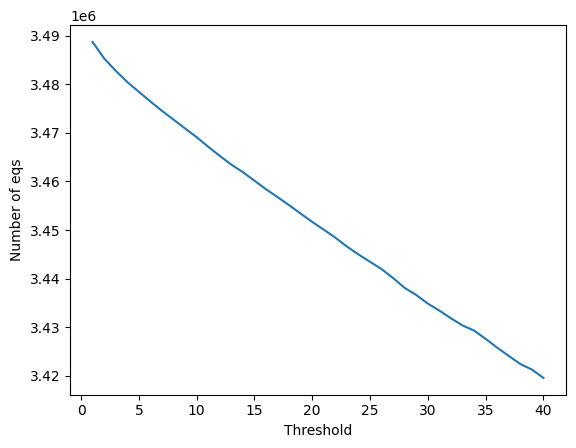

In [16]:
# plot counts
plt.plot(np.linspace(1, n, n), counts2)
plt.xlabel("Threshold")
plt.ylabel("Number of eqs")
plt.show()

In [17]:
n = 400

In [18]:
counts1 = []
counts2 = []
for th in np.linspace(1, n+1, n // 5 + 1):
    df_filter = filter_regions(df.copy(deep=True), th)
    counts1.append(df_filter["pos"].nunique())
    counts2.append(len(df_filter))

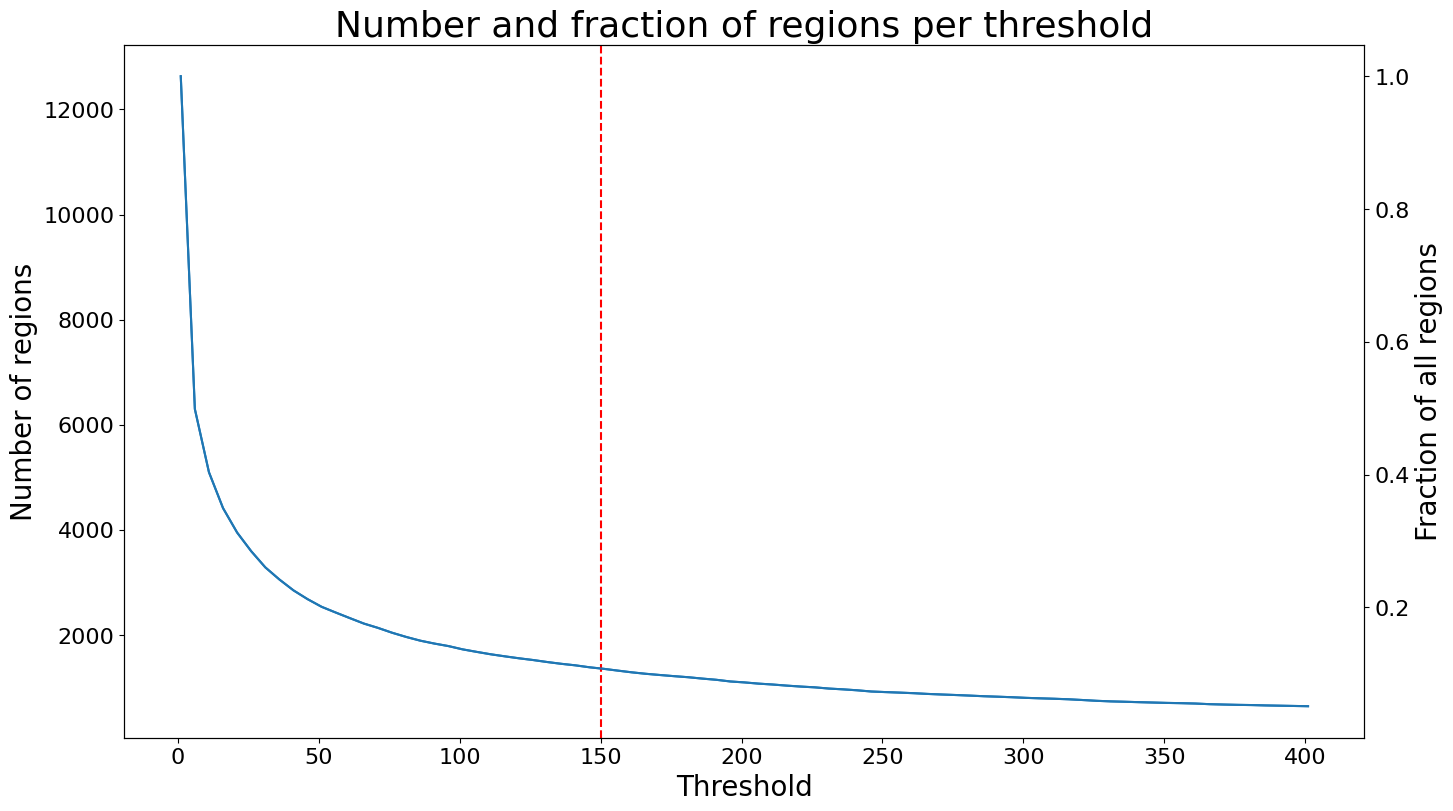

In [27]:
plt.figure(figsize=(16, 9))
plt.plot(np.linspace(1, n+1, n // 5 + 1), counts1)
plt.title("Number and fraction of regions per threshold", fontsize=26)
plt.xlabel("Threshold", fontsize=20)
plt.ylabel("Number of regions", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axvline(x=150, color="red", linestyle="--")
ax2 = plt.twinx()
ax2.plot(np.linspace(1, n+1, n // 5 + 1), np.array(counts1) / counts1[0])
ax2.set_ylabel("Fraction of all regions", fontsize=20)
ax2.tick_params(axis='y', labelsize=16)
plt.show()

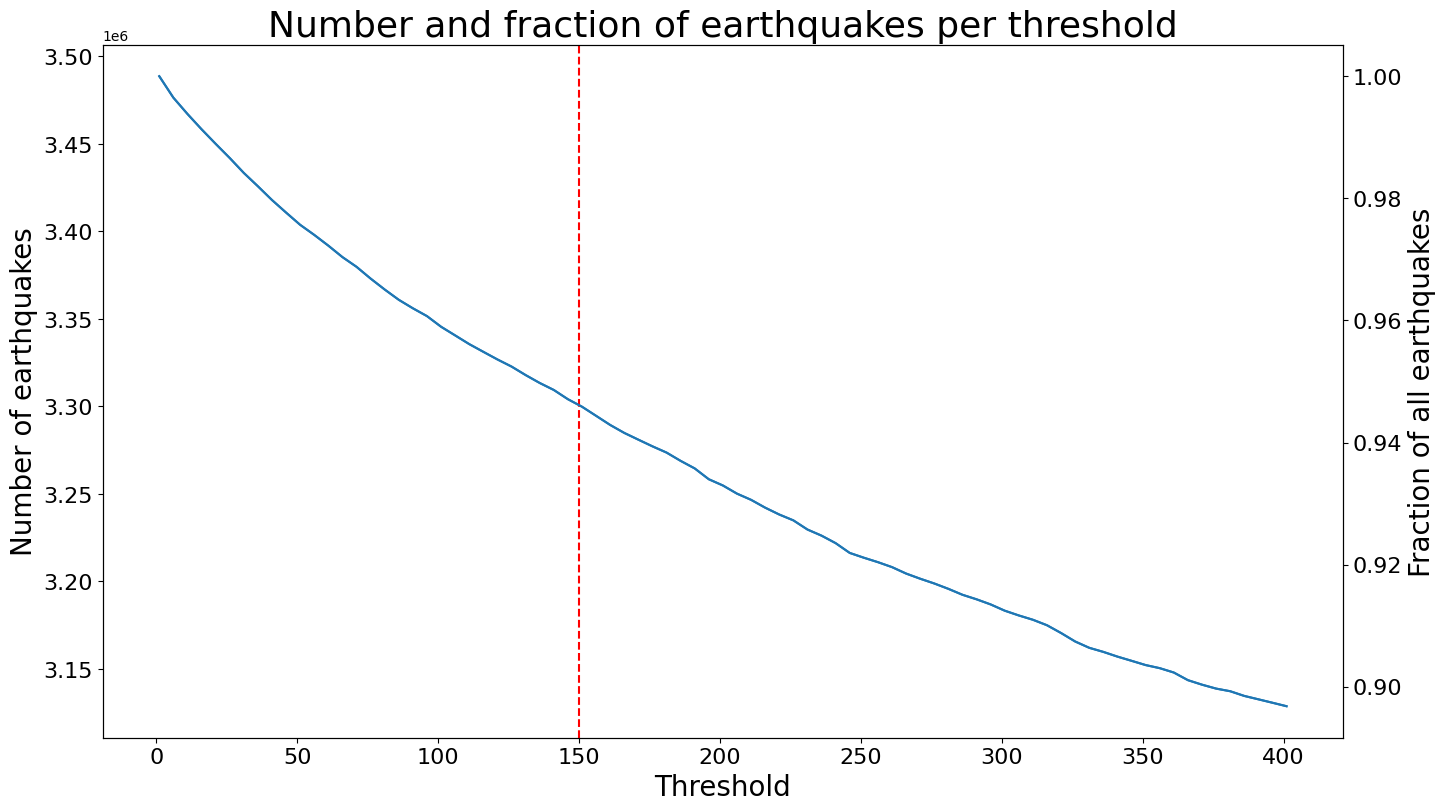

In [28]:
# plot counts
plt.figure(figsize=(16, 9))
plt.plot(np.linspace(1, n+1, n // 5 + 1), counts2)
plt.title("Number and fraction of earthquakes per threshold", fontsize=26)
plt.xlabel("Threshold", fontsize=20)
plt.ylabel("Number of earthquakes", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axvline(x=150, color="red", linestyle="--")
ax2 = plt.twinx()
ax2.plot(np.linspace(1, n+1, n // 5 + 1), np.array(counts2) / len(df_f))
ax2.set_ylabel("Fraction of all earthquakes", fontsize=20)
ax2.tick_params(axis='y', labelsize=16)
plt.show()